# Training Evnironment for Semantic Segmentation U-Net Model

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

In [2]:
torch.cuda.is_available()

True

# Load Image Data
The DataReader class is used to collate the raw jpg image data into a dataset that is appropriate for training of an image segmentation model. I've plotted some images from the dataset here as well.

The image dataset is comprised of RGB images as well as segmentation mask where people and background elements are colored differently. The DataReader() brings these images to 256x256 (and converts segmentation masks to grayscale).

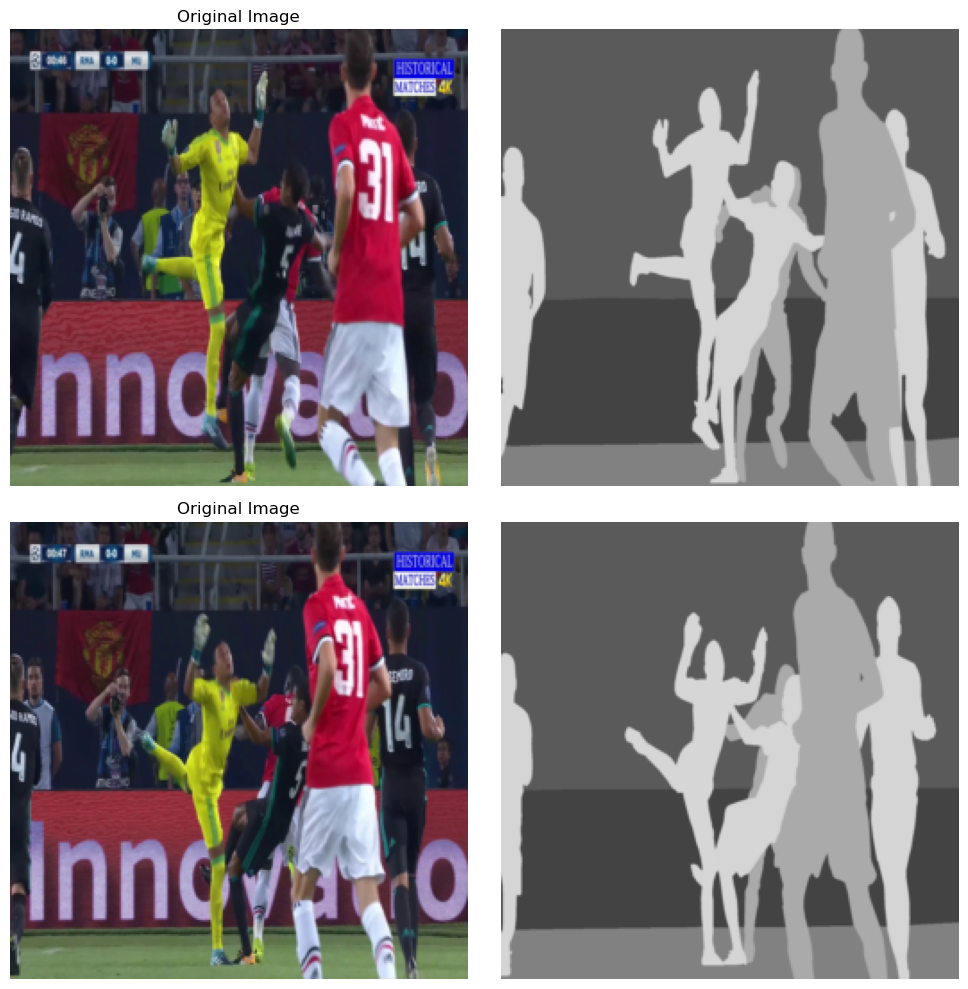

In [3]:
from dataReader import DataReader

# init data reader object
dataReader = DataReader()

# load test and train sets
trainDataset = dataReader.loadSegmentationDataset('Data/originalTrain', 'Data/segmentationTrain')
testDataset = dataReader.loadSegmentationDataset('Data/originalTest', 'Data/segmentationTest')

trainDataLoader = dataReader.wrapDataLoader(trainDataset, batchSize=10)
testDataLoader = dataReader.wrapDataLoader(testDataset, batchSize=10)

# Use the modified plotExamples method
dataReader.plot.plot_examples(testDataLoader, num_pairs=2)

# Init Model

Here I am loading in the model and setting its configurtation for training. The model is a U-Net type network with a downsampling component, followed by an upsampling component. 

The football segmentation dataset has 11 segmentation classes, but all within a single grayscale channel. 

In [4]:
from dataclasses import dataclass
from segmentationNet import SegmentationNet, SegNetConfig
import torch
import torch.nn.functional as F
from torch import nn

# set configuration
config = SegNetConfig(
    downsampling_channels=[64, 128, 256],
    upsampling_channels=[256, 128, 64],
    final_channels=[32, 16],
    num_classes=1,  # Number of segmentation classes
    channel_multiplier=2
)

# Instantiate model
model = SegmentationNet(config)

Here is the model printout

In [5]:
print(model)

SegmentationNet(
  (down_blocks): ModuleList(
    (0): Sequential(
      (0): ConvDownsamplingBlock(
        (conv): Conv2d(3, 64, kernel_size=(2, 2), stride=(1, 1), padding=same)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): ConvDownsamplingBlock(
        (conv): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1), padding=same)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Sequential(
      (0): ConvDownsamplingBlock(
        (conv): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1), padding=same)
        (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): ConvDownsamplingBlock(
        (conv): Conv2d(128, 128, kernel_size=(2, 2), stride=(1, 1), padding=same)
        (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): Sequential(
      (0): 

Here is an example forward pass using the model and dataloader.

In [6]:
# Test forward pass using dataloader

# Get a batch of data
inputs, targets = next(iter(testDataLoader))

print(f"Input Shape: {inputs.shape}")
print(f"Target Shape: {targets.shape}")

# Forward pass
outputs = model(inputs)
print(f"\nOutput Shape: {outputs.shape}")


Input Shape: torch.Size([10, 3, 256, 256])
Target Shape: torch.Size([10, 1, 256, 256])


/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /opt/conda/conda-bld/pytorch_1696588393313/work/aten/src/ATen/native/Convolution.cpp:1008.)
  return F.conv2d(input, weight, bias, self.stride,



Output Shape: torch.Size([10, 1, 256, 256])


Here I am setting up the training configuration.

Mean Squared Error is used to bring pixel scalar values of inputs into the correct range for the segmentation mask.

In [7]:
from train import Trainer, TrainConfig

# Define the trainer configuration
trainConfig = TrainConfig(
    model=model,
    trainLoader=trainDataLoader,
    testLoader=testDataLoader,
    criterion=nn.MSELoss(),
    optimizer=torch.optim.Adam(model.parameters(), lr=0.0001),
    epochs=250,
    doEarlyStopping=True,
    esPatience=10
)

# Instantiate the trainer
trainer = Trainer(trainConfig)

Training on: cuda


In [8]:
print(torch.cuda.is_available())

True


# Train the Model

In [9]:
bestModel_StateDict = trainer.train()

Epoch 1 Train Loss: 1.6204 Test Loss: 0.0196                                                        
Epoch 2 Train Loss: 0.9712 Test Loss: 0.0136                                                        
Epoch 3 Train Loss: 0.7333 Test Loss: 0.0115                                                        
Epoch 4 Train Loss: 0.6063 Test Loss: 0.0098                                                        
Epoch 5 Train Loss: 0.4918 Test Loss: 0.0082                                                        
Epoch 6 Train Loss: 0.4105 Test Loss: 0.0077                                                        
Epoch 7 Train Loss: 0.3491 Test Loss: 0.0071                                                        
Epoch 8 Train Loss: 0.2856 Test Loss: 0.0063                                                        
Epoch 9 Train Loss: 0.2571 Test Loss: 0.0054                                                        
Epoch 10 Train Loss: 0.2231 Test Loss: 0.0048                                              

# Inspect Results

In [11]:
# instantiate model from state dict
bestModel = SegmentationNet(config)
bestModel.load_state_dict(bestModel_StateDict)


Output Shape: torch.Size([10, 1, 256, 256])


In [22]:
# get batch from train
inputs, targets = next(iter(trainDataLoader))

# run forward pass on trained model
trainOutputs = bestModel(inputs)
print(f"\nOutput Shape: {outputs.shape}")


Output Shape: torch.Size([10, 1, 256, 256])


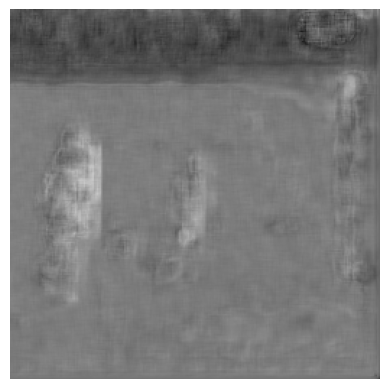

In [23]:
dataReader.plot.imshow(trainOutputs[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


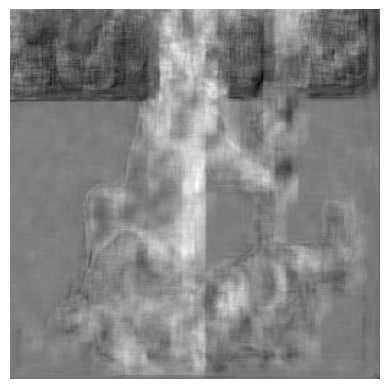

In [29]:
dataReader.plot.imshow(trainOutputs[1])

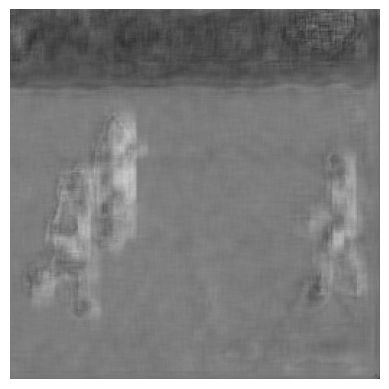

In [30]:
dataReader.plot.imshow(trainOutputs[3])

In [24]:
# get batch from test
inputs, targets = next(iter(testDataLoader))

# run forward pass on trained model
testOutputs = bestModel(inputs)
print(f"\nOutput Shape: {outputs.shape}")


Output Shape: torch.Size([10, 1, 256, 256])


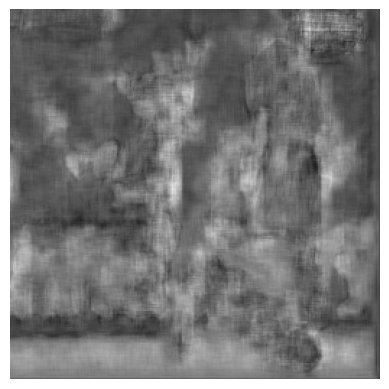

In [27]:
dataReader.plot.imshow(testOutputs[1])

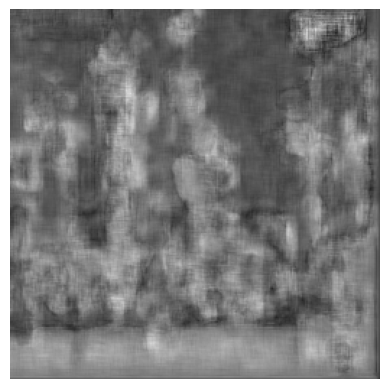

In [28]:
dataReader.plot.imshow(testOutputs[3])

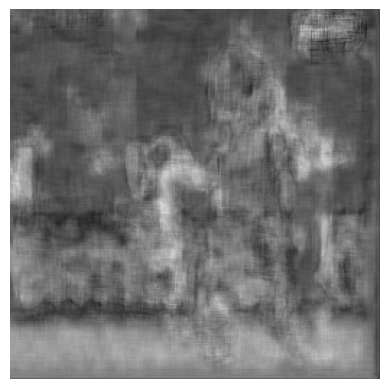

In [31]:
dataReader.plot.imshow(testOutputs[6])